<a href="https://colab.research.google.com/github/niral28/TransformersPuzzles/blob/main/EncoderDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

!pip install tiktoken
import tiktoken
tokenizer = tiktoken.encoding_for_model('gpt2')

torch.manual_seed(1337)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class SelfAttention(nn.Module):
  def __init__(self, embedding_dim:int, attention_dim: int, dropout=0.2):
    super().__init__()
    self.key_gen = nn.Linear(embedding_dim, attention_dim, bias=False) # Embedding Dim x Attention Dim
    self.query_gen = nn.Linear(embedding_dim, attention_dim, bias=False)
    self.value_gen = nn.Linear(embedding_dim, attention_dim, bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, keys, query, value, src_mask=None):
    K = self.key_gen(keys) # Batch Size X Context Length X Embedding
    Q = self.query_gen(query)
    V = self.value_gen(value)
    # print(f'Keys shape: {K.shape}')
    # print(f'Query shape: {Q.shape}')
    # print(f'Value shape: {V.shape}')
    B,T2,C = K.shape
    B,T1,C = Q.shape


    scores = Q @ torch.transpose(K, 1, 2) # Batch Size X Context Length X Context Length
    # context_length, attention_dim = K.shape[1], K.shape[2] # Assuming Embedding Dim and Attention Dim are the same
    scores =  scores * (C**-0.5)
    if src_mask is None:
      # print(f'Scores size: {scores.shape}, T1 {T1}, T2 {T2}')
      lower_triangular = torch.tril(torch.ones(T1, T2)) # T x T
      lower_triangular = lower_triangular.to(device)
      scores = scores.masked_fill(lower_triangular[:T1, :T2] == 0, float('-inf'))
    elif src_mask is not None:
      # print(f'Scores size: {scores.shape}')
      scores = scores.masked_fill(src_mask == 0, float('-inf'))
    scores = nn.functional.softmax(scores, dim=-1)
    scores = self.dropout(scores)
    return scores @ V # Tx A matrix

class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads: int, embed_size:int, attention_dim: int, dropout=0.2):
    super().__init__()
    self.head_size = attention_dim // num_heads
    self.heads = nn.ModuleList([SelfAttention(embed_size, self.head_size) for i in range(num_heads)])
    self.proj = nn.Linear(embed_size, embed_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, keys, query, value, src_mask=None):
    # Merge all the attention heads
    out = torch.cat([self.heads[i](keys, query, value, src_mask=src_mask) for i in range(len(self.heads))], dim=-1)
    out = self.dropout(self.proj(out))
    return out


class FeedForwardNetwork(nn.Module):
  def __init__(self, embed_size, forward_expansion, dropout=0.2):
    super().__init__()
    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, forward_expansion*embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size, embed_size)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, embedding):
    return self.dropout(self.feed_forward(embedding))


In [4]:
class EncoderBlock(nn.Module):
  def __init__(self, model_dim: int, num_heads: int, dropout=0.2):
    super().__init__()
    self.multihead_attn = MultiHeadAttention(num_heads, model_dim, model_dim)
    self.feed_forward = FeedForwardNetwork(model_dim, 4, dropout=dropout)
    self.norm1 = nn.LayerNorm(model_dim)
    self.norm2 = nn.LayerNorm(model_dim)

  def forward(self, embedding, src_mask):
    # print('here3')
    # if src_mask is not None:
    #   print(f'src_mask_shape:{src_mask.shape}')
    embedded = embedding + self.multihead_attn(self.norm1(embedding), self.norm1(embedding), self.norm1(embedding), src_mask=src_mask)
    embedded = embedded + self.feed_forward(self.norm2(embedded))
    return embedded

class Encoder(nn.Module):
  def __init__(self, vocab_size: int, context_length:int, model_dim: int, num_heads: int, num_blocks: int, dropout:int):
    super().__init__()
    self.word_embedding = nn.Embedding(vocab_size, model_dim)
    self.positional_embedding = nn.Embedding(context_length, model_dim)
    self.transformer_block = nn.ModuleList([
        EncoderBlock(num_heads=num_heads, model_dim=model_dim, dropout=dropout) for _ in range(num_blocks)
    ])

  def forward(self, context, src_mask):
    # print('here2')
    T = context.shape[1] # B x T x 1 (tokenized input)
    positions = torch.arange(T, device=device) # create a list from 0 -> context length
    embedding = self.word_embedding(context)+self.positional_embedding(positions)
    for layer in self.transformer_block:
      embedding = layer(embedding, src_mask=src_mask)
    return embedding

class DecoderBlock(nn.Module):
  def __init__(self, model_dim: int, num_heads: int, dropout=0.2):
    super().__init__()
    self.masked_multihead_attn = MultiHeadAttention(num_heads, model_dim, model_dim, dropout=dropout)
    self.multihead_attn = MultiHeadAttention(num_heads, model_dim, model_dim, dropout=dropout)
    self.feed_forward = FeedForwardNetwork(model_dim, 4, dropout=dropout)
    self.norm1 = nn.LayerNorm(model_dim)
    self.norm2 = nn.LayerNorm(model_dim)

  def forward(self, embedding, value, key, src_mask=None):
    # print('Masked Multi Head Attention')
    query = embedding + self.masked_multihead_attn(self.norm1(embedding), self.norm1(embedding), self.norm1(embedding), src_mask=None)
    # print('End Masked Multi Head Attention')
    # print()
    # print('Start multi-head attn')
    out = self.multihead_attn(query=self.norm2(query), value=value, keys=key, src_mask=None)
    # print('End multi-head attn')
    out = out + self.feed_forward(self.norm2(out))
    return out


class Decoder(nn.Module):
  def __init__(self, vocab_size: int, context_length:int, model_dim: int, num_heads: int, num_blocks: int, dropout=0.2):
    super().__init__()
    self.word_embedding = nn.Embedding(vocab_size, model_dim)
    self.positional_embedding = nn.Embedding(context_length, model_dim)
    self.transformer_block = nn.ModuleList([
        DecoderBlock(num_heads=num_heads, model_dim=model_dim, dropout=dropout) for _ in range(num_blocks)
    ])

  def forward(self, context, encoder_output):
    T = context.shape[1] # B x T x 1 (tokenized input)
    positions = torch.arange(T, device=device) # create a list from 0 -> context length
    embedding = self.word_embedding(context)+self.positional_embedding(positions)
    for layer in self.transformer_block:
      embedding = layer(embedding, encoder_output, encoder_output)
    return embedding


class EncoderDecoderTransformer(nn.Module):
  def __init__(self, src_vocab_size: int, trg_vocab_size:int, context_length:int, model_dim: int, num_heads: int, num_blocks: int, dropout:int, src_pad_idx=0) -> None:
    super().__init__()
    self.src_pad_idx = src_pad_idx
    self.encoder = Encoder(src_vocab_size, context_length, model_dim, num_heads, num_blocks, dropout)
    self.decoder = Decoder(trg_vocab_size, context_length, model_dim, num_heads, num_blocks, dropout)
    self.linear = nn.Linear(model_dim, trg_vocab_size)
    self.finalLayerNorm = nn.LayerNorm(model_dim) # this is recommended by researchers as it results in a more stable training

  def make_src_mask(self, src):
      src_mask = (src != self.src_pad_idx).unsqueeze(1)
      # print(f'Src mask size {src_mask.shape}')
      return src_mask.to(device)

  def forward(self, src_context, target_context, targets=None):
    src_mask = self.make_src_mask(src_context)
    # print('Start Encoder')
    encoder_output = self.encoder(src_context, src_mask)
    # print('End Encoder')
    # print()
    # print('Start Decoder')
    output = self.decoder(target_context, encoder_output)
    # print('End Decoder')
    logits = self.linear(self.finalLayerNorm(output))
    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      try:
        loss = nn.functional.cross_entropy(logits.view(B*T, C), targets.view(B*T))
      except Exception as e:
        # print(logits.shape)
        # print(logits)
        raise e
    return logits, loss



In [5]:
  src_pad_idx = 0
  trg_pad_idx = 0
  src_vocab_size = 10
  trg_vocab_size = 10
  model_dim = 256
  num_blocks=6
  num_heads = 8 # 256/8 = 32
  dropout = 0
  context_length=100
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  model = EncoderDecoderTransformer(src_vocab_size, trg_vocab_size, context_length, model_dim, num_heads, num_blocks, dropout, src_pad_idx=src_pad_idx)
  m = model.to(device)
  x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]], dtype=torch.long).to(device)
  trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]], dtype=torch.long).to(device)



In [6]:
  out = model(x, trg[:, :-1])
  print(out[0].shape)

torch.Size([2, 7, 10])


In [7]:
import zipfile

In [8]:
# !wget -c http://www.manythings.org/anki/fra-eng.zip
with zipfile.ZipFile('fra-eng.zip', 'r') as f:
  raw_text = f.read('fra.txt').decode("utf-8")

In [9]:
import csv

In [10]:
def preprocess_raw(text):
  text = text.replace('\u202f', ' ').replace('\xa0', ' ')
  out = ''
  for i, char in enumerate(text.lower()):
    if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
      out += ' '
    out += char
  return out

In [11]:
csvreader = csv.reader(raw_text.split('\n'), delimiter='\t')
english = []
french = []
for line in csvreader:
  try:
    english.append([preprocess_raw(line[0])])
    french.append([preprocess_raw(line[1])])
  except:
    print(line)

[]


In [12]:
assert len(english) == len(french)

In [13]:
english[200]

['beat it .']

In [14]:
french[200]

['casse-toi de là .']

In [15]:
english_tokens = [tokenizer.encode(sentence[0]) for sentence in english]
french_tokens = [tokenizer.encode(sentence[0]) for sentence in french]

[]

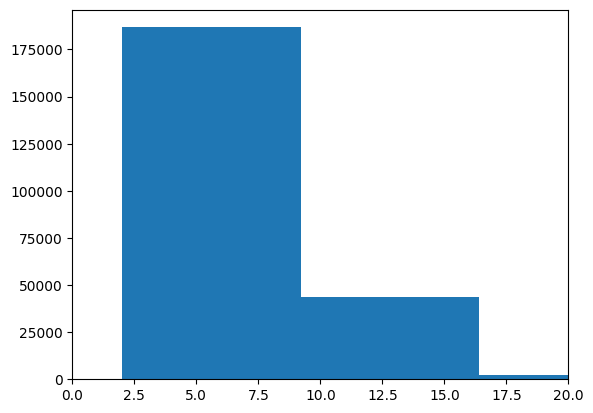

In [16]:
import matplotlib.pyplot as plt

plt.hist([len(token) for token in english_tokens])
plt.xlim([0, 20])
plt.plot()

In [17]:
english_tokens[0]

[2188, 764]

[]

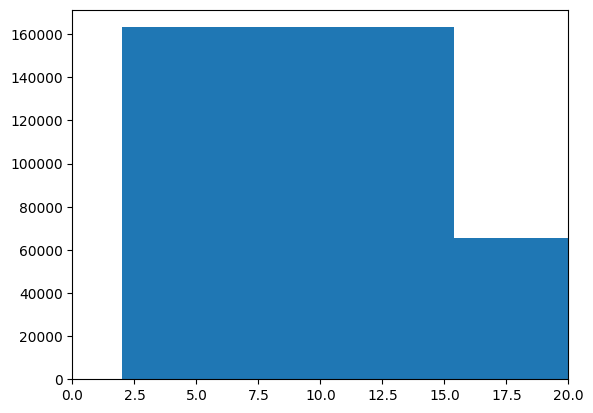

In [18]:
plt.hist([len(token) for token in french_tokens])
plt.xlim([0, 20])
plt.plot()

In [19]:
max_length = 20

In [20]:
def pad(line, max_len, padding_token):
  if len(line) > max_len:
    return line[:max_len]
  return line + [padding_token] * (max_len - len(line))


In [21]:
# Define a padding token (using <|endoftext|> in this example)
PADDING_TOKEN_ID = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]
EOS_OR_BOS_TOKEN_ID = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]


In [22]:
def build_array(lines, max_len, is_source):
  if not is_source:
    lines = [[EOS_OR_BOS_TOKEN_ID] + line + [EOS_OR_BOS_TOKEN_ID] for line in lines]
  array = torch.tensor([pad(line, max_len, PADDING_TOKEN_ID) for line in lines], dtype=torch.long)
  valid_len = (array != PADDING_TOKEN_ID).sum(1)
  return array, valid_len

In [23]:
source_english_tokens = build_array(english_tokens, 20, is_source=True)

In [24]:
source_english_tokens[0].shape

torch.Size([232736, 20])

In [25]:
target_french_tokens = build_array(french_tokens, 20, is_source=False)

In [26]:
len(target_french_tokens[0][0])

20

In [27]:
n = int(0.9*len(target_french_tokens[0])) # first 90% will be train, rest val
train_targets = target_french_tokens[0][:n]
val_targets = target_french_tokens[0][n:]
train_sources = source_english_tokens[0][:n]
val_sources = source_english_tokens[0][n:]
data = {
    'train': {
        'source': train_sources,
        'target': train_targets
    },
    'val': {
        'source': val_sources,
        'target': val_targets
    }
}


In [28]:
src_vocab_size = tokenizer.n_vocab + 1
trg_vocab_size = tokenizer.n_vocab + 1

model_dim = 256

num_blocks=6
num_heads = 8 # 256/8 = 32
dropout = 0


eval_interval = 100
learning_rate = 1e-3
eval_iters = 200
context_length = 20


batch_size = 16
model = EncoderDecoderTransformer(src_vocab_size, trg_vocab_size, context_length, model_dim, num_heads, num_blocks, dropout, src_pad_idx=PADDING_TOKEN_ID)
m = model.to(device)

In [29]:
x = torch.stack([data['train']['source'][0], data['train']['source'][1]]).to(device)
trg = torch.stack([data['train']['target'][0], data['train']['target'][1]]).to(device)

print(x)
print(trg)

tensor([[ 2188,   764, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [ 2188,   764, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]],
       device='cuda:0')
tensor([[50256,  6862,  5145, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [50256,  3876,  2395,   764, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]],
       device='cuda:0')


In [30]:
data['train']['source'][0].shape

torch.Size([20])

In [31]:
out = model(x, trg[:, :-1])
print(out[0])

tensor([[[-0.4312, -0.1402, -0.4963,  ..., -0.8133,  0.3627,  0.2460],
         [ 0.1908,  0.2890,  0.1017,  ..., -0.5134, -0.2855, -0.3214],
         [-0.1899,  0.6983, -0.2264,  ..., -0.6400,  0.8956, -0.0718],
         ...,
         [ 0.3714,  0.2383, -0.6500,  ..., -0.7064, -0.6416, -0.1030],
         [ 0.3381,  0.4696, -0.7466,  ..., -0.7122, -0.5319, -0.2513],
         [ 0.6496,  0.2278, -0.6836,  ..., -0.7015, -0.6838, -0.0694]],

        [[-0.5693, -0.1457, -0.2523,  ..., -0.3350,  0.1142,  0.0171],
         [ 0.4615,  0.2243,  0.3960,  ..., -0.5423, -0.2541, -0.3678],
         [ 0.2399, -0.0903,  0.1003,  ..., -0.9638, -0.5281, -0.0558],
         ...,
         [ 0.2424,  0.4331, -0.6417,  ..., -0.6799, -0.6046,  0.1011],
         [ 0.4753,  0.4916, -0.7281,  ..., -0.7596, -0.4643,  0.0902],
         [ 0.5850,  0.2520, -0.8098,  ..., -0.7809, -0.7187,  0.0495]]],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [36]:
def get_batch(split: str, context_length:int, batch_size: int, device:str):
  d = data[split]
  starting_idx = torch.randint(0, len(d['source'])-batch_size, (batch_size,))
  x = torch.stack([d['source'][idx] for idx in starting_idx])
  # print(x.shape)
  y = torch.stack([d['target'][idx] for idx in starting_idx])
  # print(y.shape)
  # print()
  x, y = x.to(device), y.to(device)
  return x,y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_length, batch_size, device)
            logits, loss = model(X, Y, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [38]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_length, batch_size, device)
            logits, loss = model(X, Y, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [34]:
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

49.701458 M parameters


In [39]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
max_iters = 1000
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(m)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name} grad norm: {param.grad.norm()}")
        print()
    # sample a batch of data
    xb, yb = get_batch('train', context_length, batch_size, device)

    # evaluate the loss
    logits, loss = model(xb, yb, yb)
    # print(loss)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    # for param in model.parameters():
    #   print(param.grad)
    optimizer.step()

step 0: train loss 3.9460, val loss 6.0025

step 100: train loss 3.7286, val loss 5.9837

step 200: train loss 3.6737, val loss 5.6914

step 300: train loss 3.6312, val loss 5.6558

step 400: train loss 3.6098, val loss 5.8124

step 500: train loss 3.6838, val loss 5.6815

step 600: train loss 3.5913, val loss 5.7059

step 700: train loss 3.5934, val loss 5.6008

step 800: train loss 3.5476, val loss 5.7591

step 900: train loss 3.5372, val loss 5.6018

step 999: train loss 3.5111, val loss 5.5801

